In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Dense, Embedding, LSTM
from keras.utils import np_utils
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import RandomNormal, Constant

from scipy.io import wavfile
import librosa
import librosa.display
from IPython.display import Audio
import soundfile
from pydub import AudioSegment

import os, glob, pickle
import struct

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'/Users/michelleyuu/Desktop/data255/project'

In [3]:
#os.chdir('/Users/michelleyuu/Desktop/data255/project/archive/Ravdess/audio_speech_actors_01-24/Actor_01')

os.chdir('/Users/michelleyuu/Desktop/data255/project/archive/Ravdess/audio_speech_actors_01-24')
dir_path = '/Users/michelleyuu/Desktop/data255/project/archive/Ravdess/audio_speech_actors_01-24'

In [4]:
crema_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [5]:
audios = glob.glob(os.path.join("Actor_*/*.wav"), recursive=True)


In [6]:
emotion=[emotions[i.split("-")[2]] for i in audios] 
emotionID=[i.split("-")[2] for i in audios]

data_tuples = list(zip(audios,emotion,emotionID))

metadata = pd.DataFrame(data_tuples, columns=['FileName','Emotion','EmotionID'])

In [7]:
def path_class(filename):
    excerpt = metadata[metadata['FileName'] == filename]
    path_name = os.path.join(dir_path, filename)
    return path_name, excerpt['Emotion'].values[0]
  
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [8]:
wav_fmt_data = [wav_fmt_parser(i) for i in metadata.FileName]
metadata[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)

In [9]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, sr=24000, offset=0.5)
    #result=np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=60).T, axis=0)
    result=np.array((mfcc))
    stft=np.abs(librosa.stft(y))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(y, sr=sr).T,axis=0)
    result=np.hstack((result, mel))
    return result

In [10]:
temp=extract_mfcc(metadata['FileName'][0])

X_mfcc = metadata['FileName'].apply(lambda x: extract_mfcc(x))

X = [x for x in X_mfcc]
X = np.array(X)
X.shape

enc = OneHotEncoder()
y = enc.fit_transform(metadata[['Emotion']])
y = y.toarray()

In [12]:
scaler = StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))

X_s = scaler.fit_transform(X)

In [13]:
x_train,x_test,y_train,y_test=train_test_split(np.array(X_s), y, test_size=0.25, random_state=42)

In [14]:
tensorflow.keras.backend.clear_session()

#model=MLPClassifier(alpha=0.05, batch_size=64, epsilon=1e-05, hidden_layer_sizes=(100,100,100), learning_rate='adaptive', max_iter=500)
#mlp=MLPClassifier(solver='adam', batch_size=8, hidden_layer_sizes=(250, 200, 150, 100), activation = 'relu', max_iter=900, learning_rate='adaptive', random_state=42)

#mlp=MLPClassifier(solver='adam', batch_size=8, hidden_layer_sizes=(225, 200, 175, 150, 125), activation = 'relu', learning_rate='adaptive', max_iter=500,  random_state=42) #66.94
#mlp=MLPClassifier(solver='adam', batch_size=8, hidden_layer_sizes=(400, 375, 350, 300, 275, 250, 200, 175), activation = 'relu', learning_rate='adaptive', max_iter=500)

#use 100 neurons?
#dropout?
#funnel structure
#2^x for hidden layer

mlp=MLPClassifier(solver='adam', batch_size=64, 
                  hidden_layer_sizes= (400, 350, 300, 250, 200, 150, 100), 
                  activation = 'relu', learning_rate='adaptive', learning_rate_init=0.005, 
                  max_iter=500, verbose = 1)

In [15]:
# Train the model
mlp.fit(x_train,y_train)

# Predict for the test set
y_pred=mlp.predict(x_test)

Iteration 1, loss = 3.94821683
Iteration 2, loss = 2.83754426
Iteration 3, loss = 2.53391720
Iteration 4, loss = 2.36705790
Iteration 5, loss = 2.28134458
Iteration 6, loss = 2.05545936
Iteration 7, loss = 1.91013408
Iteration 8, loss = 1.75289742
Iteration 9, loss = 1.57310952
Iteration 10, loss = 1.48559634
Iteration 11, loss = 1.31084576
Iteration 12, loss = 1.38223236
Iteration 13, loss = 1.15265983
Iteration 14, loss = 1.14776263
Iteration 15, loss = 1.08901209
Iteration 16, loss = 0.84966654
Iteration 17, loss = 0.90139098
Iteration 18, loss = 0.82301548
Iteration 19, loss = 0.93860254
Iteration 20, loss = 0.73360395
Iteration 21, loss = 0.66804107
Iteration 22, loss = 0.75360393
Iteration 23, loss = 0.75715437
Iteration 24, loss = 0.51439666
Iteration 25, loss = 0.39504243
Iteration 26, loss = 0.55761348
Iteration 27, loss = 0.27551333
Iteration 28, loss = 0.24955136
Iteration 29, loss = 0.44077561
Iteration 30, loss = 0.34800826
Iteration 31, loss = 0.53672591
Iteration 32, los

In [16]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 59.44%


In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        48
           1       0.87      0.80      0.84        51
           2       0.74      0.65      0.69        48
           3       0.54      0.47      0.50        47
           4       0.70      0.33      0.44        49
           5       0.52      0.50      0.51        26
           6       0.54      0.63      0.58        41
           7       0.68      0.76      0.72        50

   micro avg       0.68      0.59      0.63       360
   macro avg       0.68      0.59      0.62       360
weighted avg       0.69      0.59      0.63       360
 samples avg       0.59      0.59      0.59       360



In [18]:
tensorflow.keras.backend.clear_session()

model = models.Sequential() 
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'valid', activation="relu", input_shape=(x_train.shape[1],1)))

model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'valid', activation="relu"))

#model.add(BatchNormalization(renorm=True))
#model.add(layers.ZeroPadding1D(padding = 1))

model.add(Dropout(0.50))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dense(128, activation = "relu"))

#model.add(Dropout(0.20))

model.add(layers.Dense(y.shape[1], activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"]) #rmsprop
model.summary() 

#traditional machine learning methods - classification
#number of layers/neruons

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 197, 128)          640       
                                                                 
 conv1d_1 (Conv1D)           (None, 194, 128)          65664     
                                                                 
 dropout (Dropout)           (None, 194, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 97, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12416)             0         
                                                                 
 dense (Dense)               (None, 256)               3178752   
                                                        

In [19]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'max', 
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=10,
                                            verbose=1,
                                            factor=0.05,
                                            min_lr=0.00001)

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [20]:
EPOCHS = 100
batch_size = 16

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/100
68/68 [==============================] - 3s 32ms/step - loss: 1.8496 - acc: 0.2806 - val_loss: 1.7021 - val_acc: 0.3417 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 2s 29ms/step - loss: 1.5137 - acc: 0.4324 - val_loss: 1.6114 - val_acc: 0.4250 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 2s 31ms/step - loss: 1.2661 - acc: 0.5241 - val_loss: 1.4481 - val_acc: 0.4722 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 2s 29ms/step - loss: 1.0167 - acc: 0.6250 - val_loss: 1.4766 - val_acc: 0.4639 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 2s 30ms/step - loss: 0.8059 - acc: 0.7056 - val_loss: 1.2470 - val_acc: 0.5722 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 2s 30ms/step - loss: 0.5805 - acc: 0.7963 - val_loss: 1.2860 - val_acc: 0.5861 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 2s 29ms/step - loss: 0.4777 - acc: 0.8306 - val_loss: 1.5571 - val_acc: 0.572

12/12 [==============================] - 0s 9ms/step - loss: 1.4784 - acc: 0.7056
Accuracy of our model on test data :  70.55555582046509 %


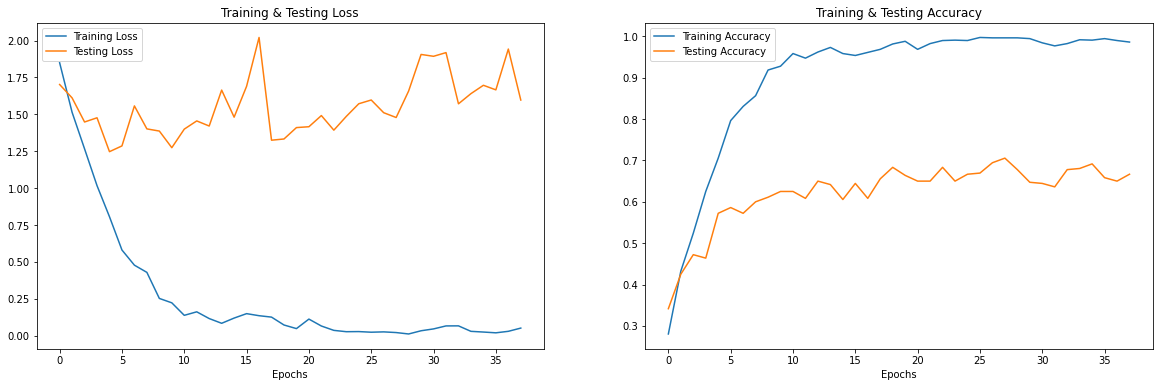

In [21]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [403]:
tensorflow.keras.backend.clear_session()

model = models.Sequential() 
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'same', input_shape=(x_train.shape[1],1)))
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'same', activation="relu"))
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'same', activation="relu"))

model.add(BatchNormalization())

model.add(Dropout(0.50))

model.add(layers.ZeroPadding1D(padding = 1))
model.add(MaxPooling1D(pool_size=3, padding='same', strides = 1))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.15))
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization(momentum=0.995, 
                             epsilon=0.005, 
                             beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                             gamma_initializer=Constant(value=0.995)))

#model.add(Dropout(0.20))

model.add(layers.Dense(y.shape[1], activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"]) #rmsprop
model.summary() 

#traditional machine learning methods - classification
#number of layers/neruons

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 128)          640       
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 128)          65664     
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 128)          65664     
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 202, 128)         0         
 1D)                                                    

In [404]:
EPOCHS = 100
batch_size = 16

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction]) #callbacks=[earlystopping, learning_rate_reduction]

Epoch 1/100
68/68 [==============================] - 8s 98ms/step - loss: 2.0717 - acc: 0.2287 - val_loss: 1.8249 - val_acc: 0.3472 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 6s 95ms/step - loss: 1.8267 - acc: 0.2972 - val_loss: 1.7577 - val_acc: 0.3639 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 6s 93ms/step - loss: 1.7014 - acc: 0.3389 - val_loss: 1.8006 - val_acc: 0.2778 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 6s 93ms/step - loss: 1.6644 - acc: 0.3630 - val_loss: 1.6884 - val_acc: 0.3444 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 6s 95ms/step - loss: 1.5618 - acc: 0.3963 - val_loss: 1.8151 - val_acc: 0.2917 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 6s 93ms/step - loss: 1.4873 - acc: 0.4685 - val_loss: 1.6570 - val_acc: 0.3806 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 6s 92ms/step - loss: 1.3786 - acc: 0.4750 - val_loss: 1.5625 - val_acc: 0.402

12/12 [==============================] - 0s 17ms/step - loss: 1.3124 - acc: 0.7028
Accuracy of our model on test data :  70.27778029441833 %


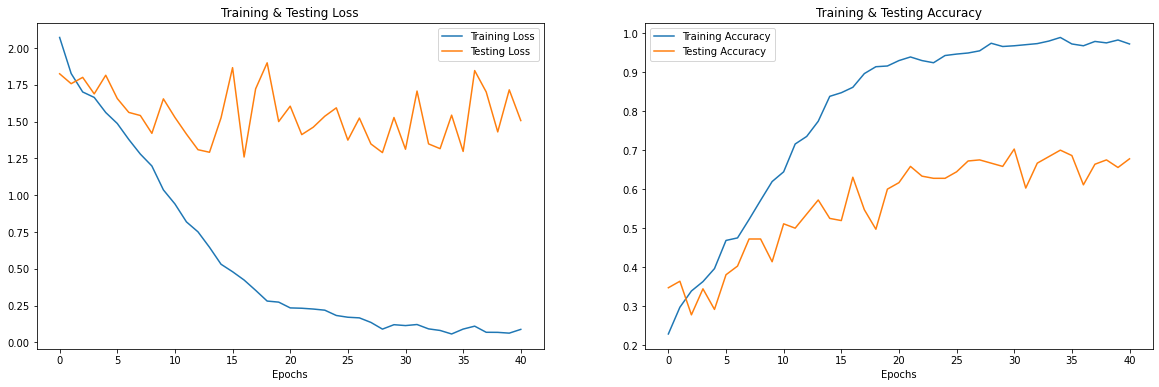

In [406]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [377]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 0s 18ms/step - loss: 1.3957 - acc: 0.7111


[1.3956531286239624, 0.7111111283302307]

In [378]:
yhat = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat,1)
y_true_classes = np.argmax(y_test,1)

In [379]:
f1 = f1_score(y_true_classes,yhat_classes,pos_label='positive'
                                           ,average='micro')
print('F1 score: %f' % f1)

F1 score: 0.711111


In [441]:
tensorflow.keras.backend.clear_session()

model = models.Sequential() 
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'same', input_shape=(x_train.shape[1],1)))
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'same', activation="relu"))
model.add(Conv1D(filters = 128, kernel_size = 4, padding = 'same', activation="relu"))

model.add(BatchNormalization())

model.add(Dropout(0.50))

model.add(layers.ZeroPadding1D(padding = 1))
model.add(MaxPooling1D(pool_size=3, padding='same', strides = 2))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.20))
model.add(BatchNormalization())

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization(momentum=0.997, 
                             epsilon=0.005, 
                             beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                             gamma_initializer=Constant(value=0.995)))

#model.add(Dropout(0.20))

model.add(layers.Dense(y.shape[1], activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"]) #rmsprop
model.summary() 

#traditional machine learning methods - classification
#number of layers/neruons

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 128)          640       
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 128)          65664     
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 128)          65664     
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 202, 128)         0         
 1D)                                                    

In [442]:
EPOCHS = 100
batch_size = 16

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction]) #callbacks=[earlystopping, learning_rate_reduction]

Epoch 1/100
68/68 [==============================] - 6s 73ms/step - loss: 2.5360 - acc: 0.1352 - val_loss: 2.0705 - val_acc: 0.1278 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 5s 75ms/step - loss: 2.3149 - acc: 0.1352 - val_loss: 2.0507 - val_acc: 0.2167 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 5s 71ms/step - loss: 2.1716 - acc: 0.1639 - val_loss: 2.0295 - val_acc: 0.1917 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 5s 70ms/step - loss: 2.0706 - acc: 0.1944 - val_loss: 2.0452 - val_acc: 0.1917 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 5s 68ms/step - loss: 2.0559 - acc: 0.2204 - val_loss: 2.1745 - val_acc: 0.1972 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 5s 68ms/step - loss: 1.9779 - acc: 0.2157 - val_loss: 2.1331 - val_acc: 0.2222 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 5s 69ms/step - loss: 1.9723 - acc: 0.2222 - val_loss: 2.0199 - val_acc: 0.250

12/12 [==============================] - 0s 17ms/step - loss: 1.7688 - acc: 0.3417
Accuracy of our model on test data :  34.166666865348816 %


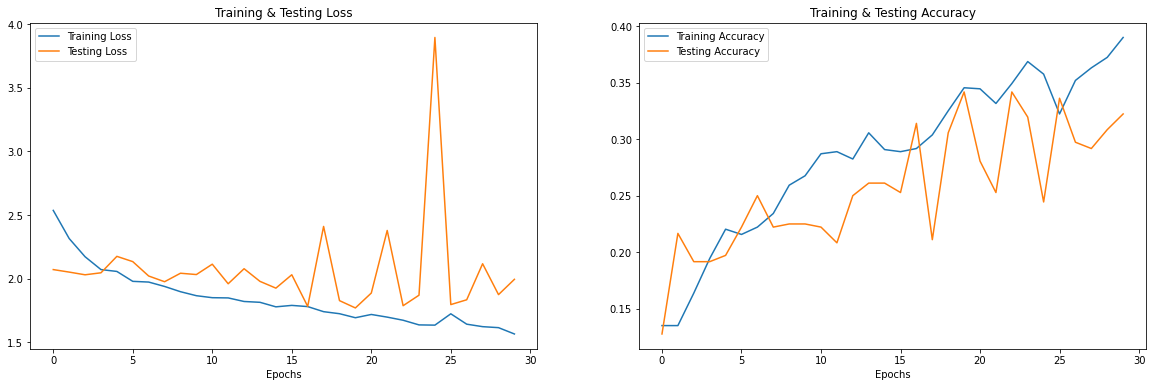

In [443]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [325]:
tensorflow.keras.backend.clear_session()

lstm = models.Sequential() 
lstm.add(LSTM(256, input_shape=(x_train.shape[1], 1), return_sequences = False))
lstm.add(BatchNormalization())

lstm.add(Dense(128))
lstm.add(Dropout(0.3))

lstm.add(Dense(128, activation = "relu"))
lstm.add(Dropout(0.3))

lstm.add(Dense(64))
lstm.add(Dropout(0.3))

lstm.add(Dense(64, activation = "relu"))
lstm.add(Dropout(0.3))

lstm.add(Dense(32, activation = "relu"))

lstm.add(layers.Dense(8, activation="softmax"))

lstm.summary() 

lstm.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [318]:
earlystopping_lstm = EarlyStopping(monitor ="val_loss",
                              mode = 'max', patience = 10, verbose = 1,
                              restore_best_weights = True)

learning_rate_reduction_lstm = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.05,
                                            min_lr=0.00001)

In [326]:
EPOCHS = 50
batch_size = 64

history = lstm.fit(x_train, y_train, validation_data=(x_test, y_test),
                    epochs=EPOCHS, batch_size=batch_size
                    ) #callbacks=[earlystopping_lstm, learning_rate_reduction_lstm]

Epoch 1/50
17/17 [==============================] - 8s 336ms/step - loss: 2.1303 - accuracy: 0.1667 - val_loss: 2.0588 - val_accuracy: 0.2444
Epoch 2/50
17/17 [==============================] - 5s 318ms/step - loss: 2.0546 - accuracy: 0.1889 - val_loss: 2.0602 - val_accuracy: 0.1889
Epoch 3/50
17/17 [==============================] - 5s 316ms/step - loss: 2.0367 - accuracy: 0.1815 - val_loss: 2.0543 - val_accuracy: 0.1667
Epoch 4/50
17/17 [==============================] - 5s 323ms/step - loss: 2.0017 - accuracy: 0.2037 - val_loss: 2.0621 - val_accuracy: 0.1778
Epoch 5/50
17/17 [==============================] - 6s 336ms/step - loss: 1.9566 - accuracy: 0.2157 - val_loss: 2.0581 - val_accuracy: 0.1639
Epoch 6/50
17/17 [==============================] - 5s 324ms/step - loss: 1.9546 - accuracy: 0.1981 - val_loss: 2.0680 - val_accuracy: 0.1139
Epoch 7/50
17/17 [==============================] - 6s 340ms/step - loss: 1.9644 - accuracy: 0.2222 - val_loss: 2.0863 - val_accuracy: 0.1361
Epoch 

12/12 [==============================] - 1s 63ms/step - loss: 1.8735 - accuracy: 0.2639
Accuracy of our model on test data :  26.38888955116272 %


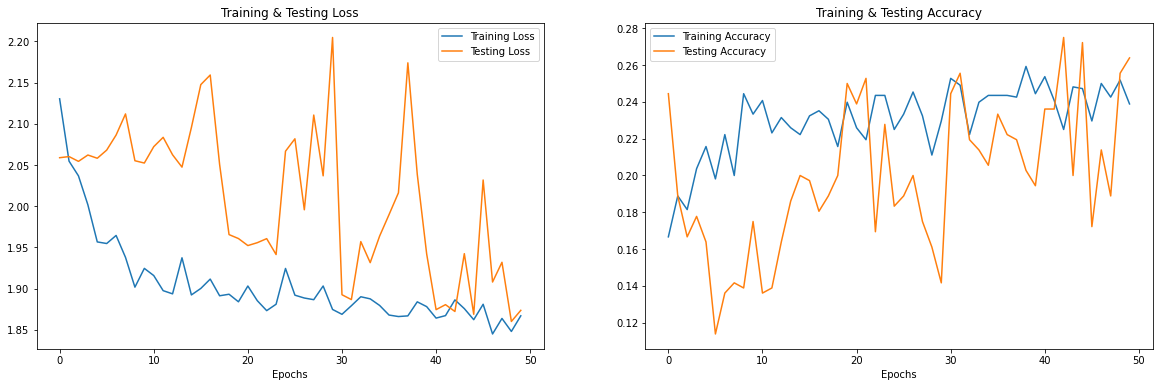

In [327]:
print("Accuracy of our model on test data : " , lstm.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lstm.evaluate(x_test,y_test)

12/12 [==============================] - 1s 42ms/step - loss: nan - accuracy: 0.1333


[nan, 0.13333334028720856]

In [ ]:
yhat = lstm.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat,1)
y_true_classes = np.argmax(y_test,1)

In [ ]:
f1 = f1_score(y_true_classes,yhat_classes,pos_label='positive'
                                           ,average='micro')
print('F1 score: %f' % f1)

F1 score: 0.133333


In [ ]:
XD

NameError: name 'XD' is not defined

https://www.kaggle.com/essamkhames/speech-emotion-recognition   
https://www.kaggle.com/code/eward96/speech-emotion-detection    
https://github.com/fatihkykc/EmotionRecognitionFromAudio/blob/master/speech_emotion_recognition.ipynb   



In [ ]:
model = models.Sequential() #reduce neurons? add pooling, less hidden layers
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(layers.Flatten())
for _ in range(10):
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

model.summary()


In [ ]:
MLP = MLPClassifier(alpha = 0.01, batch_size = 32, hidden_layer_sizes = (64,32,32,16,8), learning_rate = 'adaptive', max_iter = 215)

# Train model with data
#MLP.fit(x_train, y_train)

# Predict on test set
#y_pred = MLP.predict(x_test)



In [ ]:
# Check accuracy of predictions
accuracy = accuracy_score(y_test, y_pred=y_pred)
print("accuracy: %.2f%%" % (accuracy * 100))

accuracy: 43.59%


accuracy: 0.45%


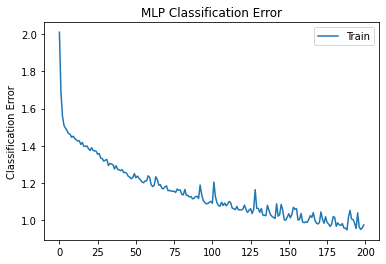

In [ ]:
MLP.fit(x_train, y_train)
train_pred = MLP.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, train_pred)
print("accuracy: %.2f%%" % (accuracy))
#get results
x_axis = range(0, MLP.n_iter_)
fig, ax = plt.subplots()
ax.plot(x_axis, MLP.loss_curve_, label='Train')
ax.legend()
plt.ylabel('Classification Error')
plt.title('MLP Classification Error')
plt.show()

In [ ]:
xx

In [ ]:
#audio_arrays = []

#for i in data_pd['file_path']:
#    x, sr = librosa.load(i, sr=sample_rate, mono = False) #sr = 24000
#    audio_arrays.append(x)
    
#data_pd['Arrays'] = audio_arrays

#warnings.filterwarnings('ignore')

#x = []
#y = []
#for i in range(len(data_pd)):
#    feature=get_features(data_pd['Arrays'].iloc[i]);
#    for j in feature:
#        x.append(j)
#        y.append(data_pd['emotion'].iloc[i])

In [ ]:
def noise(data, rate = .05):
    noise_amp = rate * np.random.uniform()*np.amax(data)  
    data = data.astype('float64') + (noise_amp*np.random.normal(size=data.shape[0]))
    return data

## Feature extraction (Only MFCC)
def extract_feature(file_name, mfcc, chroma, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype = "float32")
    X = noise(X) # data augmentation 
    #sample_rate = sound_file.samplerate
    sample_rate = 24000
    result = np.array([])
    stft = np.abs(librosa.stft(X))
    if mfcc:
      mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 30).T, axis = 0)
      result = np.hstack((result, mfccs))
    if chroma:
      chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      result = np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

# Function to load and split data after feature extraction
def load_data(test_size):
  x,y = [],[]
  for file in glob.glob(dir_path+"/*.wav"):
      file_name = os.path.basename(file)

      #set audio to Stereo
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")
      
      emotion = crema_emotions[file_name.split("_")[2]]
      feature = extract_feature(file, mfcc = True, chroma = True, mel= True)
      x.append(feature)
      y.append(emotion)
      
  #x_n = preprocessing.normalize([x])
  return train_test_split(np.array(x), y, test_size, random_state = 42)
  #return x, y

In [ ]:
processed_data = []

for root, dirs, files in os.walk(dir_path):
    for file in files:
        #print(file)
        file_path = os.path.join(root, file)

        dataset = root.split('/')[7]
        #print(dataset)
        if dataset == 'Crema':
            emotion = emotions[file.split('_')[2]]
            processed_data.append([file_path, emotion])

data_pd = pd.DataFrame(processed_data, columns = ['file_path', 'emotion'])

duration_list = []

for i in range(len(data_pd)):
    y, sr = librosa.load(data_pd['file_path'][i])
    s = librosa.stft(y)
    dur = librosa.get_duration(S=s, sr = sr)
    duration_list.append(dur)

def create_waveplot(data, sample_rate, emotion):
    plt.figure(figsize=(14, 5))
    plt.title('Waveplot for {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()


test1, sr1 = librosa.load(data_pd['file_path'][0], sr = 24000, offset = 0)

create_waveplot(test1, sr1, emotion)

for emotion in crema_emotions.values():
    path = (data_pd[data_pd.emotion == emotion].iloc[0])[0]
    data, sample_rate = librosa.load(path)
    create_waveplot(data, sample_rate, emotion)
    #Audio(path)

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html